In [2]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
import sklearn
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
df = pd.read_csv('/home/javier/Downloads/Kaggle_datasets/Steam games/archive/steam.csv')

df

In [4]:
df1 = df.copy()

In [5]:
df1.drop(columns=['release_date', 'english', 'platforms', 'required_age', 'steamspy_tags'], inplace=True)

df1

### Drop duplicates

In [6]:
duplicates = df1[df1.duplicated(subset=['appid'], keep=False)]

duplicates

In [7]:
# Group to aggregate all rows into one
df_aggregated = df1.groupby('appid')['categories'].agg(lambda x: ';'.join(x)).reset_index()

df_aggregated

In [8]:
df1.drop_duplicates(subset=['appid'], inplace=True)

In [9]:
df_merged = pd.merge(df1, df_aggregated, on='appid', how='left', suffixes=('_original', '_aggregated'))

In [10]:
df_merged['categories_original'] = df_merged['categories_aggregated']

In [11]:
df_merged = df_merged.drop(columns=['categories_aggregated'])

In [12]:
df_merged.rename(columns={'categories_original':'categories'}, inplace=True)

df_merged

In [13]:
df1 = df_merged.copy()

In [14]:
df_desc = pd.read_csv('/home/javier/Downloads/Kaggle_datasets/Steam games/archive/steam_description_data.csv')

In [15]:
df_desc.rename(columns={'steam_appid':'appid'},inplace=True)

df_desc

In [16]:
final_df = df1.merge(df_desc, on = 'appid', how= 'inner')

final_df

In [17]:
df3 = final_df.copy()

In [18]:
df3['developer'] = df3['developer'].astype(str)
df3['publisher'] = df3['publisher'].astype(str)
df3['developer'] = df3['developer'].str.replace(' ', '').str.split(';')
df3['publisher'] = df3['publisher'].str.replace(' ', '').str.split(';')
df3['owners'] = df3['owners'].apply(lambda x: int(x.split('-')[1]) if '-' in x else int(x))
df3['categories'] = df3['categories'].str.split(';')
df3['genres'] = df3['genres'].str.split(';')
df3['categories'] = df3['categories'].apply(lambda x: [i.replace(' ', '') for i in x])
df3['categories'] = df3['categories'].apply(lambda x: [i.replace('-', '') for i in x])
df3['detailed_description'] = df3['detailed_description'].apply(lambda x: x.split())
df3['about_the_game'] = df3['about_the_game'].apply(lambda x: x.split())
df3['short_description'] = df3['short_description'].apply(lambda x: x.split())

df3

In [19]:
# will not take into account the ratings as they should be normalized together
numerical_columns = ['achievements', 'average_playtime', 'median_playtime', 'owners', 'price']
ratings_df = df3[['positive_ratings', 'negative_ratings']]

In [20]:
# Data normalization
min_max_scaler = preprocessing.MinMaxScaler()
for column in numerical_columns:
    df3[column] = min_max_scaler.fit_transform(df3[[column]])

inputs_scaled=min_max_scaler.fit_transform(ratings_df)
inputs_n=pd.DataFrame(inputs_scaled,columns=ratings_df.columns)

df3

In [21]:
df_merged2 = pd.merge(df3, inputs_n, left_index=True, right_index=True)

In [22]:
df_merged2.drop(columns=['positive_ratings_x','negative_ratings_x'], inplace=True)
df_merged2.rename(columns={'positive_ratings_y':'positive_ratings', 'negative_ratings_y': 'negative_ratings'}, inplace=True)

df_merged2

In [23]:
# taking only the short description into account as its the only one without the <> characters
df_merged2['tags'] = df_merged2['developer'] + df_merged2['publisher'] + df_merged2['categories'] + df_merged2['short_description'] + df_merged2['genres']

In [24]:
# convert the values from a list to a string but add a space in between while also making it all lowercase
df_merged2['tags'] = df_merged2['tags'].apply(lambda x: ' '.join(map(str, x)))
df_merged2['tags'] = df_merged2['tags'].apply(lambda x: x.lower())

In [25]:
df4 = df_merged2[['appid', 'name', 'tags', 'achievements', 'average_playtime', 'median_playtime', 'owners', 'price']].copy()

In [26]:
# concatenate numerical columns
num_cols = ['achievements', 'average_playtime', 'median_playtime', 'owners', 'price']
scaler = MinMaxScaler()
numerical_data = scaler.fit_transform(df4[num_cols])

In [27]:
# concatenate text and remove stop words
stop_words = ENGLISH_STOP_WORDS
text_data = df4['tags'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
vectorizer = CountVectorizer()
text_data = vectorizer.fit_transform(text_data).toarray()

In [28]:
all_features = np.concatenate((numerical_data, text_data), axis=1)

In [29]:
all_features.shape

(27075, 56708)

In [30]:
similarity = cosine_similarity(all_features)

In [31]:
def recommend(game, top_n=5):
    index = df4.index[df4['name'] == game].tolist()[0]
    similar_games = sorted(enumerate(similarity[index]), key=lambda x: x[1], reverse=True)[1:top_n+1]

    recommended_games = [df4['name'][i[0]] for i in similar_games]
    return recommended_games

In [36]:
game_to_recommend = "Mass Effect"
recommended_games = recommend(game_to_recommend)

print(f"Recommended games for {game_to_recommend}:")
for game in recommended_games:
    print(game)

Recommended games for Mass Effect:
Mighty Action RPG
Goblin Quest: Escape!
Amethlion
Sakura and Crit: The Mock Game
Rebel Galaxy


In [62]:
# using nearest neighbors method
from sklearn.neighbors import NearestNeighbors

neighbors_model = NearestNeighbors(metric='euclidean', n_neighbors=6)  # You can adjust the metric and n_neighbors as needed
neighbors_model.fit(all_features)

NearestNeighbors(metric='euclidean', n_neighbors=6)

In [63]:
def recommend_nn(game, top_n=5):
    index = df4.index[df4['name'] == game].tolist()[0]
    distances, indices = neighbors_model.kneighbors([all_features[index]], n_neighbors=top_n+1)  # Add 1 to include the game itself

    recommended_games = [df4['name'][i] for i in indices.flatten()[1:]]  # Exclude the game itself
    return recommended_games

# Example usage:
game_to_recommend = 'Dota 2'
recommended_games = recommend_nn(game_to_recommend)

print(f"Recommended games for {game_to_recommend}:")
for game in recommended_games:
    print(game)

Recommended games for Dota 2:
Triggerun
Day of Defeat: Source
The Settlers Online
b
Stormbound


Recommended games for Counter-Strike:
Team Fortress Classic
Ricochet
Half-Life
Scrunk
Slapshot


In [55]:
games=df4['name'].unique().tolist()

In [56]:
games

['Counter-Strike',
 'Team Fortress Classic',
 'Day of Defeat',
 'Deathmatch Classic',
 'Half-Life: Opposing Force',
 'Ricochet',
 'Half-Life',
 'Counter-Strike: Condition Zero',
 'Half-Life: Blue Shift',
 'Half-Life 2',
 'Counter-Strike: Source',
 'Half-Life: Source',
 'Day of Defeat: Source',
 'Half-Life 2: Deathmatch',
 'Half-Life 2: Lost Coast',
 'Half-Life Deathmatch: Source',
 'Half-Life 2: Episode One',
 'Portal',
 'Half-Life 2: Episode Two',
 'Team Fortress 2',
 'Left 4 Dead',
 'Left 4 Dead 2',
 'Dota 2',
 'Portal 2',
 'Alien Swarm',
 'Counter-Strike: Global Offensive',
 'Rag Doll Kung Fu',
 'Red Orchestra: Ostfront 41-45',
 'Killing Floor',
 'SiN Episodes: Emergence',
 'Darwinia',
 'Uplink',
 'DEFCON',
 'Multiwinia',
 'Dangerous Waters',
 'Space Empires IV Deluxe',
 'Disciples II: Rise of the Elves ',
 "Disciples II: Gallean's Return",
 'Iron Warriors: T - 72 Tank Command ',
 'Space Empires V',
 'Arx Fatalis',
 'Source Filmmaker',
 'Earth 2160',
 'Two Worlds Epic Edition',
 'Da

In [44]:
df4 = df_merged2[['achievements', 'average_playtime', 'median_playtime', 'owners', 'price']].copy()

In [45]:
df_text = df_merged2[['appid', 'name', 'tags']].copy()

In [46]:
# concatenate the numerical data

In [ ]:
scaler = MinMaxScaler()
numerical_cols = ['achievements', 'average_playtime', 'median_playtime', 'owners', 'price']
numerical_data = scaler.fit_transform(df[numerical_columns])

In [295]:
a = 'TeSgT'

In [296]:
a.lower()

'tesgt'

In [218]:
df1['categories'] = df1['categories'].str.split(';')  # Split the strings into lists
df2 = df1.explode('categories')  # Transform lists into separate rows
unique_values = df2['categories'].str.strip().unique()

In [219]:
unique_values

array(['Multi-player', 'Online Multi-Player', 'Local Multi-Player',
       'Valve Anti-Cheat enabled', 'Single-player', 'Steam Cloud',
       'Steam Achievements', 'Steam Trading Cards', 'Captions available',
       'Partial Controller Support', 'Includes Source SDK',
       'Cross-Platform Multiplayer', 'Stats', 'Commentary available',
       'Includes level editor', 'Steam Workshop', 'In-App Purchases',
       'Co-op', 'Full controller support', 'Steam Leaderboards',
       'SteamVR Collectibles', 'Online Co-op', 'Shared/Split Screen',
       'Local Co-op', 'MMO', 'VR Support', 'Mods', 'Mods (require HL2)',
       'Steam Turn Notifications'], dtype=object)

In [220]:
for value in unique_values: 
    df1[value] = 0

In [221]:
df1

,appid,release_date,developer,publisher,categories,genres,achievements,positive_ratings,negative_ratings,average_playtime,...,Steam Leaderboards,SteamVR Collectibles,Online Co-op,Shared/Split Screen,Local Co-op,MMO,VR Support,Mods,Mods (require HL2),Steam Turn Notifications
0,10,2000-11-01,Valve,Valve,"[Multi-player, Online Multi-Player, Local Mult...",Action,0,124534,3339,17612,...,0,0,0,0,0,0,0,0,0,0
1,20,1999-04-01,Valve,Valve,"[Multi-player, Online Multi-Player, Local Mult...",Action,0,3318,633,277,...,0,0,0,0,0,0,0,0,0,0
2,30,2003-05-01,Valve,Valve,"[Multi-player, Valve Anti-Cheat enabled]",Action,0,3416,398,187,...,0,0,0,0,0,0,0,0,0,0
3,40,2001-06-01,Valve,Valve,"[Multi-player, Online Multi-Player, Local Mult...",Action,0,1273,267,258,...,0,0,0,0,0,0,0,0,0,0
4,50,1999-11-01,Gearbox Software,Valve,"[Single-player, Multi-player, Valve Anti-Cheat...",Action,0,5250,288,624,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,2019-04-24,SHEN JIAWEI,SHEN JIAWEI,"[Single-player, Steam Achievements]",Adventure;Casual;Indie,7,3,0,0,...,0,0,0,0,0,0,0,0,0,0
27071,1065570,2019-04-23,Semyon Maximov,BekkerDev Studio,[Single-player],Action;Adventure;Indie,0,8,1,0,...,0,0,0,0,0,0,0,0,0,0
27072,1065650,2019-04-24,EntwicklerX,EntwicklerX,"[Single-player, Multi-player, Co-op, Shared/Sp...",Action;Casual;Indie,24,0,1,0,...,0,0,0,0,0,0,0,0,0,0
27073,1066700,2019-04-17,Yustas Game Studio,Alawar Entertainment,"[Single-player, Steam Cloud]",Adventure;Casual;Indie,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [222]:
for index, row in df1.iterrows():
    for col_name in unique_values:
        if col_name in row['categories']:
            df1.at[index, col_name] = 1

In [223]:
df1.drop(columns=['categories'], inplace=True)

In [224]:
df1

,appid,release_date,developer,publisher,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,...,Steam Leaderboards,SteamVR Collectibles,Online Co-op,Shared/Split Screen,Local Co-op,MMO,VR Support,Mods,Mods (require HL2),Steam Turn Notifications
0,10,2000-11-01,Valve,Valve,Action,0,124534,3339,17612,317,...,0,0,0,0,0,0,0,0,0,0
1,20,1999-04-01,Valve,Valve,Action,0,3318,633,277,62,...,0,0,0,0,0,0,0,0,0,0
2,30,2003-05-01,Valve,Valve,Action,0,3416,398,187,34,...,0,0,0,0,0,0,0,0,0,0
3,40,2001-06-01,Valve,Valve,Action,0,1273,267,258,184,...,0,0,0,0,0,0,0,0,0,0
4,50,1999-11-01,Gearbox Software,Valve,Action,0,5250,288,624,415,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,2019-04-24,SHEN JIAWEI,SHEN JIAWEI,Adventure;Casual;Indie,7,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27071,1065570,2019-04-23,Semyon Maximov,BekkerDev Studio,Action;Adventure;Indie,0,8,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27072,1065650,2019-04-24,EntwicklerX,EntwicklerX,Action;Casual;Indie,24,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
27073,1066700,2019-04-17,Yustas Game Studio,Alawar Entertainment,Adventure;Casual;Indie,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Repeat the same with the genres column

In [225]:
df1['genres'] = df1['genres'].str.split(';')  # Split the strings into lists
df2 = df1.explode('genres')  # Transform lists into separate rows
unique_values = df2['genres'].str.strip().unique()

In [226]:
unique_values

array(['Action', 'Free to Play', 'Strategy', 'Adventure', 'Indie', 'RPG',
       'Animation & Modeling', 'Video Production', 'Casual', 'Simulation',
       'Racing', 'Violent', 'Massively Multiplayer', 'Nudity', 'Sports',
       'Early Access', 'Gore', 'Utilities', 'Design & Illustration',
       'Web Publishing', 'Education', 'Software Training',
       'Sexual Content', 'Audio Production', 'Game Development',
       'Photo Editing', 'Accounting', 'Documentary', 'Tutorial'],
      dtype=object)

In [227]:
for value in unique_values: 
    df1[value] = 0

In [228]:
for index, row in df1.iterrows():
    for col_name in unique_values:
        if col_name in row['genres']:
            df1.at[index, col_name] = 1

In [229]:
df1.drop(columns=['genres'], inplace=True)

In [230]:
df1

,appid,release_date,developer,publisher,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,...,Web Publishing,Education,Software Training,Sexual Content,Audio Production,Game Development,Photo Editing,Accounting,Documentary,Tutorial
0,10,2000-11-01,Valve,Valve,0,124534,3339,17612,317,7.19,...,0,0,0,0,0,0,0,0,0,0
1,20,1999-04-01,Valve,Valve,0,3318,633,277,62,3.99,...,0,0,0,0,0,0,0,0,0,0
2,30,2003-05-01,Valve,Valve,0,3416,398,187,34,3.99,...,0,0,0,0,0,0,0,0,0,0
3,40,2001-06-01,Valve,Valve,0,1273,267,258,184,3.99,...,0,0,0,0,0,0,0,0,0,0
4,50,1999-11-01,Gearbox Software,Valve,0,5250,288,624,415,3.99,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,2019-04-24,SHEN JIAWEI,SHEN JIAWEI,7,3,0,0,0,2.09,...,0,0,0,0,0,0,0,0,0,0
27071,1065570,2019-04-23,Semyon Maximov,BekkerDev Studio,0,8,1,0,0,1.69,...,0,0,0,0,0,0,0,0,0,0
27072,1065650,2019-04-24,EntwicklerX,EntwicklerX,24,0,1,0,0,3.99,...,0,0,0,0,0,0,0,0,0,0
27073,1066700,2019-04-17,Yustas Game Studio,Alawar Entertainment,0,2,0,0,0,5.19,...,0,0,0,0,0,0,0,0,0,0


In [16]:
cats = np.array(df.categories)
genres = np.array(df.genres)

In [17]:
genres

array(['Action', 'Action', 'Action', ..., 'Action;Casual;Indie',
       'Adventure;Casual;Indie', 'Adventure;Casual;Indie'], dtype=object)

In [18]:
text_data = cats
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(text_data, show_progress_bar = True)

Batches:   0%|          | 0/847 [00:00<?, ?it/s]

In [20]:
embeddings

array([[-0.16162579, -1.0200536 ,  0.22360727, ..., -0.0493871 ,
        -0.0910504 , -0.6977471 ],
       [-0.16162573, -1.0200537 ,  0.22360761, ..., -0.04938701,
        -0.09105064, -0.69774693],
       [-0.36437967, -0.9356005 ,  0.2682293 , ..., -0.22797412,
        -0.1383592 , -0.73609406],
       ...,
       [-0.46494478, -1.1373794 ,  0.13009688, ..., -0.4201841 ,
         0.0109634 , -0.86200494],
       [-0.9002511 , -1.1998035 , -0.34991637, ..., -0.7708149 ,
         0.21512607, -0.65220565],
       [-0.9002511 , -1.1998035 , -0.34991637, ..., -0.7708149 ,
         0.21512607, -0.65220565]], dtype=float32)

In [21]:
n_comp = 5
pca = PCA(n_components=n_comp)
pca.fit(embeddings)
pca_data = pd.DataFrame(pca.transform(embeddings))
pca_data.head()

,0,1,2,3,4
0,-4.692920,7.449512,2.710808,1.083700,-2.443810
1,-4.692920,7.449511,2.710808,1.083700,-2.443810
2,-2.392407,6.466760,1.911763,-1.117737,-2.445176
3,-4.692920,7.449511,2.710808,1.083700,-2.443810
4,-1.380989,5.647039,1.312917,-1.793785,-1.345912


/home/javier/anaconda3/envs/steam/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


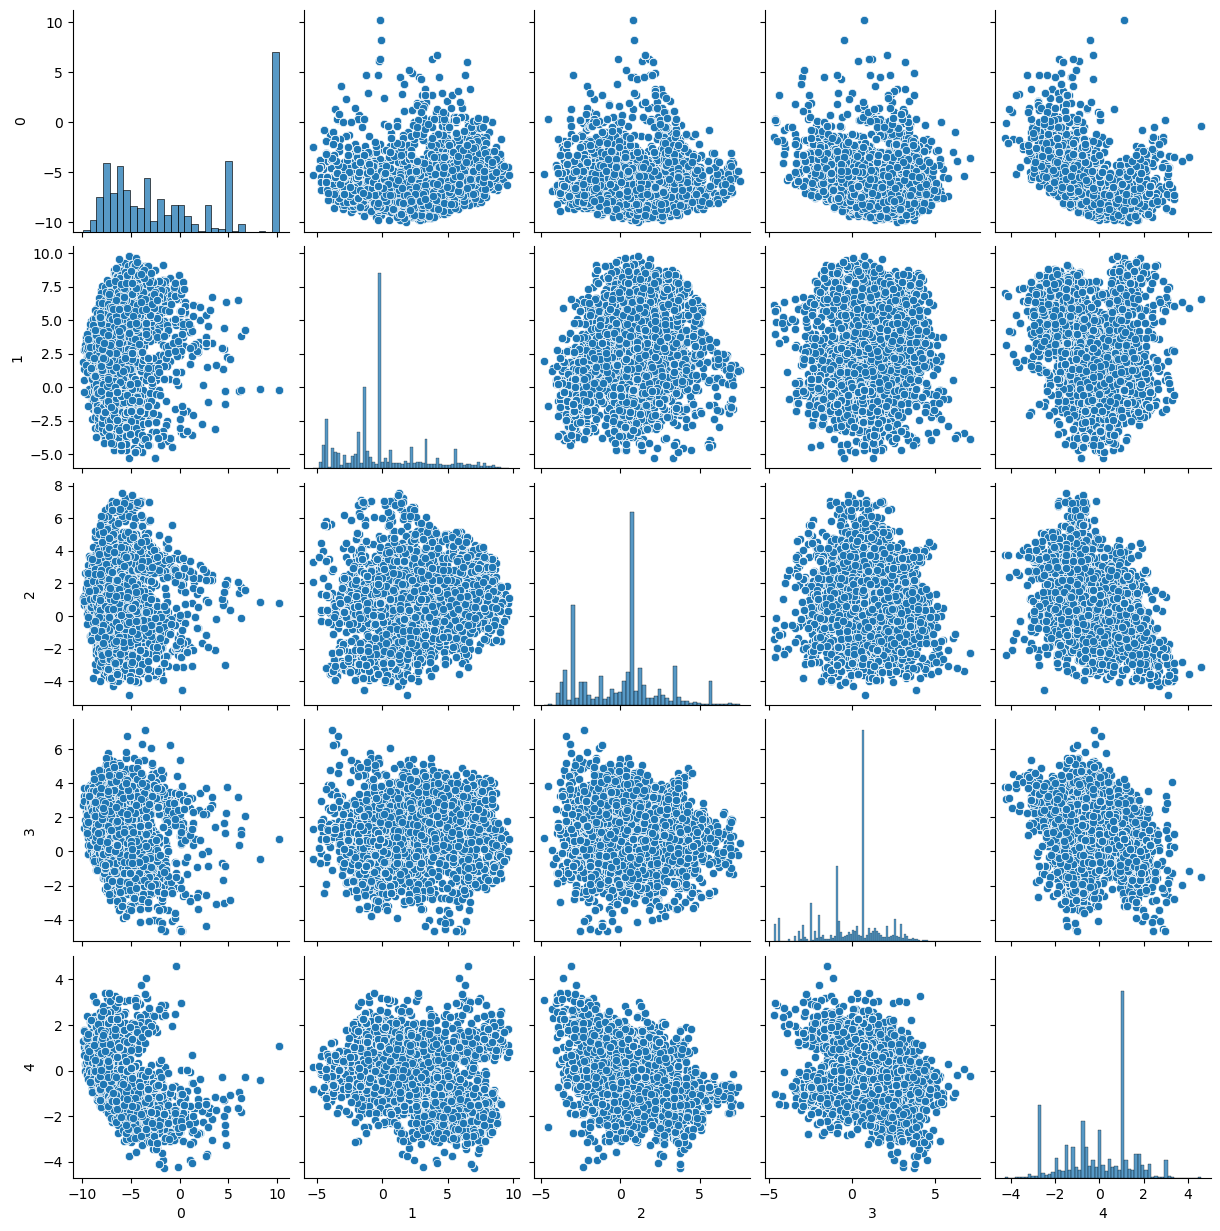

In [22]:
sns.pairplot(pca_data)